In [1]:
import os

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

# 1. Data Preparation

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile

## Get Data

In [3]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

--2020-12-09 10:08:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   123MB/s    in 0.5s    

2020-12-09 10:08:53 (123 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [4]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

## Define Directories

In [5]:
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs') 

validation_cats_dir = os.path.join(validation_dir, 'cats') 
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Preprocess

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 20, 
    target_size = (150,150),
    class_mode = "binary"
)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    target_size = (150, 150),
    class_mode = "binary"
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 2. Model

## Get pretrained model

In [7]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-12-09 10:08:54--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 74.125.204.128, 2404:6800:4008:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  18.9MB/s    in 4.4s    

2020-12-09 10:08:59 (18.9 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



## Setup and load pretrained model

In [8]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None
)

pre_trained_model.load_weights(local_weights_file)

## Freeze Layers

In [9]:
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Pick where to cut off model

In [10]:
last_layer = pre_trained_model.get_layer('mixed7')
print(last_layer.output_shape)
last_output = last_layer.output

(None, 7, 7, 768)


## Build Customized Model

In [13]:
from tensorflow.keras.optimizers import RMSprop

x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(1, activation="sigmoid")(x)

model = Model(pre_trained_model.input, x)

In [14]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Compile the Model

In [15]:
model.compile( loss = "binary_crossentropy", optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])

## Train the Model

In [17]:
history = model.fit(
    train_generator,
    epochs = 2,
    steps_per_epoch = 100,
    verbose = 2,
    validation_data = valid_generator,
    validation_steps = 50
)

Epoch 1/2
100/100 - 133s - loss: 0.3050 - accuracy: 0.8695 - val_loss: 0.1942 - val_accuracy: 0.9230
Epoch 2/2
100/100 - 132s - loss: 0.2126 - accuracy: 0.9145 - val_loss: 0.0956 - val_accuracy: 0.9620


## Plot loss and accuracy

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

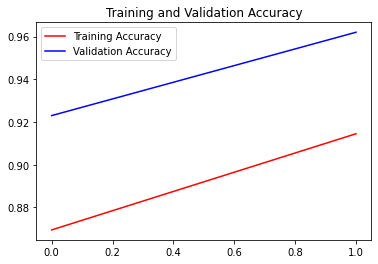

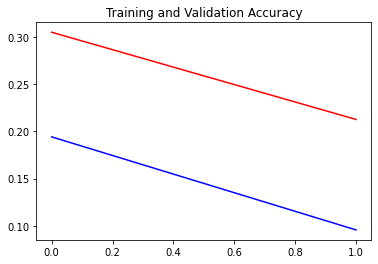

In [23]:
# extract info
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(train_acc))

# plot
plt.plot(epochs, train_acc, color="r", label="Training Accuracy")
plt.plot(epochs, val_acc, color="b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, train_loss, color="r", label="Training Loss")
plt.plot(epochs, val_loss, color="b", label="Validation Loss")
plt.title("Training and Validation Accuracy")
plt.show()

In [ ]:
""